In [21]:
from utils.file_handling import get_snapshot_images_path, json_folder_path, load_json_by_page
from llm.snapshot import get_snapshots
from llm.connectors.dspy_chat import DSPyChat
from PIL import Image
import pprint

working_set = "evaluation_challenges"
page_number = 13

Get the json path and matrices.

In [3]:
# Define the path to the data folder
folder_path = json_folder_path(working_set)

# Call the function from data_initialize.py for page number 3
result = load_json_by_page(folder=folder_path, page_number=page_number)

train_inputs = [elem['input'] for elem in result['train']]
test_inputs = [elem['input'] for elem in result['test']]
train_outputa = [elem['output'] for elem in result['train']]

processed_json/evaluation_challenges/013_0a2355a6.json


Generate the snapshots for the given working set and page number.

In [4]:
import pygame
pygame.init()
get_snapshots(working_set, page_number)
pygame.quit()

processed_json/evaluation_challenges/013_0a2355a6.json
processed_json/evaluation_solutions/013_0a2355a6.json
processed_json/evaluation_challenges/013_0a2355a6.json
processed_json/evaluation_solutions/013_0a2355a6.json
[PosixPath('snapshots/evaluation_challenges/13/train_0_pair.jpg')]


Initiate a DSPy Chat session with Gemini model. Load a single training pair image and ask for the causation between input and output.

In [38]:
images_path = get_snapshot_images_path(working_set, page_number, grid_type='train', index=None, grid_name='pair')
imgs = [Image.open(p) for p in images_path]

print(images_path)

dspy_instance = DSPyChat()

[PosixPath('snapshots/evaluation_challenges/13/train_1_pair.jpg'), PosixPath('snapshots/evaluation_challenges/13/train_0_pair.jpg'), PosixPath('snapshots/evaluation_challenges/13/train_2_pair.jpg'), PosixPath('snapshots/evaluation_challenges/13/train_3_pair.jpg')]


In [32]:
response = dspy_instance.send_message(imgs[0], "What do you see in the image? Do you see a pair of girds?")
print(response)
analyze_causation = []
response_causation = []
analyze_causation.append(f"""You are right. The image on the left is an input grid and the image on the right on the right is the output grid.
Pertaining to some hidden rule, the output grid was constructed from the input grid by applying the rule. I would like you to guess the most likely explanation that led from the
input grid to the output grid. Tell me the most likely explanation.
""")
response_causation.append(dspy_instance.send_message(analyze_causation[0]))
pprint.pprint(response_causation[0])

('The most likely rule is: **Each connected component in the input grid is '
 'assigned a unique color in the output grid, and the components are moved to '
 'the top left corner of the grid, while maintaining their relative '
 'positions.**\n'
 '\n'
 "Here's why:\n"
 '\n'
 '* **Color Mapping:** Each distinct connected group of orange squares in the '
 'input corresponds to a uniquely colored shape in the output (green, blue, '
 'red).\n'
 '* **Relocation:** The shapes in the output grid maintain the same relative '
 'positions as the connected components in the input grid, but they are '
 'shifted to the top left. \n'
 '* **Background:** The black squares in the input grid seem to be ignored or '
 'treated as background.\n'
 '\n'
 'This explanation is simple, consistent with the observed pattern, and '
 "doesn't require any complex assumptions. \n")


Now lets analyze the second pair.

In [33]:
instruction = """Now I want you to analyze another pair of training images. The same rule that applied to previous pair applies here too."""
analyze_causation.append(f"""Pertaining to the same hidden rule, the output grid was constructed from the input grid again by applying the same rule. 
                         I would like you to guess the most likely explanation that led from the input grids to the output grids. 
                         Remeber that your first explanation might have been incomplete or wrong.
                         It is a good idea to update the explanation so that it is more likely to explain upcoming questions where only input image would be shown.
                         Tell me the udpated most likely explanation. Also tell me what changes have you made for the new explanation compared to the previous one.

""")

response_causation.append(dspy_instance.send_message(imgs[1], analyze_causation[1]))

pprint.pprint(response_causation[1])

("You're right, my previous explanation was incomplete!  There's more to the "
 'pattern than just color mapping and relocation. \n'
 '\n'
 "Here's the updated explanation:\n"
 '\n'
 '**The rule identifies closed loops formed by the orange squares in the input '
 'grid. Each closed loop is assigned a unique color in the output grid. The '
 'loops are then extracted and placed in the top left corner of the output '
 'grid, maintaining their relative positions and orientations.**\n'
 '\n'
 "Here's how this explanation improves upon the previous one:\n"
 '\n'
 '* **Closed Loops:** The key difference is the focus on **closed loops** '
 'rather than just connected components. This explains why some orange squares '
 "in the input don't get mapped to the output – they are not part of a closed "
 'loop.\n'
 '* **Orientation:** The new explanation also accounts for the fact that the '
 'shapes in the output grid maintain the same orientation as the corresponding '
 'loops in the input grid.\n'

In [34]:
instruction = """Now I want you to analyze another pair of training images. The same rule that applied to previous pair applies here too."""
dspy_instance.send_message(instruction)
response_causation.append(dspy_instance.send_message(imgs[2], analyze_causation[-1]))

pprint.pprint(response_causation[2])

('My previous explanation about closed loops seems to hold up well with this '
 "new example! Let's break it down to confirm:\n"
 '\n'
 '* **Closed Loops:**  The input grid has three distinct closed loops formed '
 'by the orange squares. \n'
 '* **Color Mapping:** Each closed loop in the input grid corresponds to a '
 'uniquely colored shape in the output grid (red, blue, green).\n'
 '* **Relocation and Orientation:** The colored shapes in the output grid '
 'maintain the same relative positions and orientations as the corresponding '
 'loops in the input grid. They are moved to the top left corner, but their '
 'structure within themselves is unchanged.\n'
 '\n'
 '**No changes are needed to the previous explanation.** This example '
 'reinforces that the rule is focused on identifying and extracting closed '
 'loops, not just connected components. \n'
 '\n'
 "I'm feeling more confident about this rule now!  Let's see if we can test it "
 'with more examples. \n')


In [45]:
query_generate_grid = """ I want you to take a good look at the input grid that I provide. 
For this grid, I want you to generate a  matrix (python list of lists - let call it inp_mat) for the provided grid.
The matrix should have the same dimensions as the input grid and there should be one to one correspondence between the input grid and the matrix that you generate.
The first list in the inp_mat should correspond to the first row in the input grid and the second list should correspond to the second row in the input grid.
Similarly the first element in the second list should correspond to the first cell in the second row and so on.
len(inp_mat) == number of rows in the input grid. len(inp_mat[0] = inp_mat[1] = inp_mat[2] ...) == number of columns in the input grid.
Use the colour schema that I am defining here. 
                                [ 0: (0, 0, 0),          # Black
                                  1: (255, 0, 0),        # Red
                                  2: (0, 255, 0),        # Green
                                  3: (0, 0, 255),        # Blue
                                  4: (255, 255, 0),      # Yellow
                                  5: (255, 0, 255),      # Magenta
                                  6: (0, 255, 255),      # Cyan
                                  7: (128, 0, 128),      # Purple
                                  8: (255, 165, 0),      # Orange
                                  9: (0, 128, 128)       # Teal  ]
For example, a 3*3 grid with all black cells but one single red cell in the middle should be represented as:
[[0, 0, 0],
 [0, 1, 0],
 [0, 0, 0]]
Using this knowledge, write a matrix as list of lists for the provided input grid in image.
 """
train_3_input_path = get_snapshot_images_path(working_set, page_number, grid_type='train', index=3, grid_name='input')
train_3_input = Image.open(train_3_input_path[0])

result = dspy_instance.send_message(train_3_input, query_generate_grid)
print(result)

```python
inp_mat = [
    [0, 0, 0, 0, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 0],
    [0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 8, 0, 0, 0, 0, 0, 8, 8, 8, 0, 0],
    [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0],
    [0, 0, 8, 8, 8, 0, 0, 0, 0, 0, 8, 8, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]
``` 



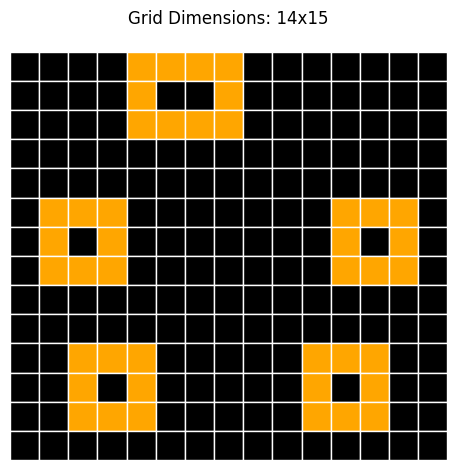

Opening "/tmp/tmp43tewhss.PNG" with GNU Image Manipulation Program  (image/png)


Use of uninitialized value $file in open at /usr/share/perl5/File/MimeInfo/Applications.pm line 140.
Use of uninitialized value $file in open at /usr/share/perl5/File/MimeInfo/Applications.pm line 140.
Use of uninitialized value in subroutine entry at /usr/share/perl5/File/BaseDir.pm line 105.
Use of uninitialized value in subroutine entry at /usr/share/perl5/File/BaseDir.pm line 105.
Use of uninitialized value in subroutine entry at /usr/share/perl5/File/BaseDir.pm line 105.
Use of uninitialized value in subroutine entry at /usr/share/perl5/File/BaseDir.pm line 105.
Use of uninitialized value $file in open at /usr/share/perl5/File/MimeInfo/Applications.pm line 140.
Use of uninitialized value $file in open at /usr/share/perl5/File/MimeInfo/Applications.pm line 140.
Use of uninitialized value in subroutine entry at /usr/share/perl5/File/BaseDir.pm line 105.
Use of uninitialized value in subroutine entry at /usr/share/perl5/File/BaseDir.pm line 105.
Use of uninitialized value in subrouti

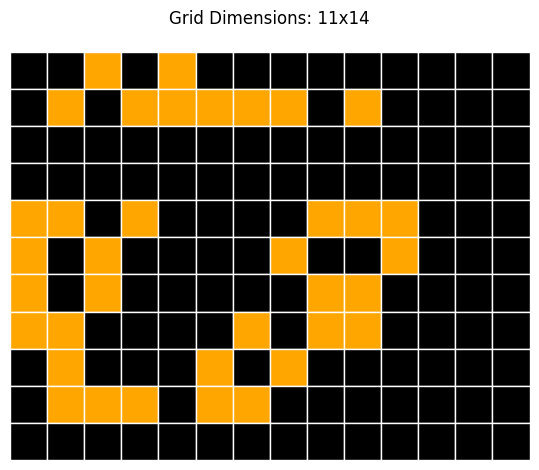

In [46]:
from GUI.matplotlib.create_grid_image import create_grid_image

train_3_input.show()

gemini_matrix = [
    [0, 0, 0, 0, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 8, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 0],
    [0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 0],
    [0, 8, 8, 8, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 8, 8, 8, 0, 0, 0, 0, 0, 8, 8, 8, 0, 0],
    [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 8, 0, 8, 0, 0],
    [0, 0, 8, 8, 8, 0, 0, 0, 0, 0, 8, 8, 8, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

create_grid_image(gemini_matrix)

claude_matrix = [
    [0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 8, 0, 8, 8, 8, 8, 8, 0, 8, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [8, 8, 0, 8, 0, 0, 0, 0, 8, 8, 8, 0, 0, 0],
    [8, 0, 8, 0, 0, 0, 0, 8, 0, 0, 8, 0, 0, 0],
    [8, 0, 8, 0, 0, 0, 0, 0, 8, 8, 0, 0, 0, 0],
    [8, 8, 0, 0, 0, 0, 8, 0, 8, 8, 0, 0, 0, 0],
    [0, 8, 0, 0, 0, 8, 0, 8, 0, 0, 0, 0, 0, 0],
    [0, 8, 8, 8, 0, 8, 8, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]

create_grid_image(claude_matrix)